# Stroke stats checks

Check the stats.

This notebook uses more age bands (0-64, 65-69, 70-74, 75-79, and 80+ years old), Index of Mean Deprivation, and health bands (good health, fair health, and bad health).

## Code setup

In [1]:
import os
import polars as pl
import numpy as np

from scipy.optimize import minimize
import statsmodels.api as sm  # for linear regression

import matplotlib.pyplot as plt

## Load data

Patient demographics by MSOA:

In [2]:
path_to_msoa_stats = os.path.join('data', 'msoa_collated.csv')

df_stats_old = pl.read_csv(path_to_msoa_stats)

In [3]:
df_stats_old.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761


Link MSOA names and codes:

In [4]:
path_to_msoa = os.path.join('data', 'Output_Area_to_LSOA_to_MSOA_to_Local_Authority_District_(December_2017)_Lookup_with_Area_Classifications_in_Great_Britain.csv')

df_msoa_names_codes = pl.read_csv(path_to_msoa)

In [5]:
df_msoa_names_codes = df_msoa_names_codes.unique(subset='MSOA11CD')[['MSOA11CD', 'MSOA11NM']]

In [6]:
df_msoa_names_codes

MSOA11CD,MSOA11NM
str,str
"""E02006671""","""Wiltshire 056"""
"""E02005373""","""Harborough 007"""
"""E02005553""","""King's Lynn and West Norfolk 0…"
"""E02006382""","""Reigate and Banstead 008"""
"""E02005397""","""North West Leicestershire 001"""
…,…
"""E02003429""","""Windsor and Maidenhead 009"""
"""E02003867""","""Cheshire East 015"""
"""S02002075""","""Rural Keith and Strathisla"""


In [7]:
df_stats_old = df_stats_old.join(df_msoa_names_codes, left_on='MSOA', right_on='MSOA11NM', how='left')

df_stats_old.head(3)

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534"""
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535"""
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536"""


Newer stats dataframe with age band info:

In [8]:
path_to_msoa_stats = os.path.join('data', 'collated_data_regional_msoa11cd.csv')

df_stats = pl.read_csv(path_to_msoa_stats)

In [9]:
df_stats.head()

msoa11cd,polygon_area_km2,population_density,income_domain_weighted_mean,imd_weighted_mean,weighted_ivt_time,mt_time_weighted_mean,ivt_time_weighted_mean,mt_transfer_time_weighted_mean,ethnic_group_other_than_white_british,ethnic_group_all_categories_ethnic_group,ethnic_minority_proportion,bad_or_very_bad_health,all_categories_general_health,bad_health_proportion,long_term_health_count,all_categories_long_term_health_problem_or_disability,long_term_health_proportion,age_65_plus_count,population_all,age_65_plus_proportion,age_band_all_0,age_0_proportion,age_band_all_5,age_5_proportion,age_band_all_10,age_10_proportion,age_band_all_15,age_15_proportion,age_band_all_20,age_20_proportion,age_band_all_25,age_25_proportion,age_band_all_30,age_30_proportion,age_band_all_35,age_35_proportion,age_band_all_40,age_40_proportion,age_band_all_45,age_45_proportion,age_band_all_50,age_50_proportion,age_band_all_55,age_55_proportion,age_band_all_60,age_60_proportion,age_band_all_65,age_65_proportion,age_band_all_70,age_70_proportion,age_band_all_75,age_75_proportion,age_band_all_80,age_80_proportion,age_band_all_85,age_85_proportion,age_band_all_90,age_90_proportion,rural_False,rural_True,proportion_rural,over_65_within_30_False,over_65_within_30_True,proportion_over_65_within_30,closest_is_mt_False,closest_is_mt_True,proportion_closest_is_mt
str,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""E02000001""",7.4935,1459.6557,0.0693,15.4842,10.9293,10.7663,10.7663,0.0,3132,7375,0.4247,246,7375,0.0334,835,7187,0.1162,1731,10938,0.1583,474,0.0433,646,0.0591,465,0.0425,455,0.0416,1061,0.097,1445,0.1321,795,0.0727,680,0.0622,538,0.0492,663,0.0606,764,0.0698,672,0.0614,549,0.0502,508,0.0464,474,0.0433,300,0.0274,217,0.0198,116,0.0106,116,0.0106,10938.0,0.0,0.0,0.0,1731.0,1.0,0.0,10938.0,1.0
"""E02000002""",5.603,1378.9128,0.2165,34.8123,13.3056,13.2008,13.2008,0.0,2861,6775,0.4223,495,6775,0.0731,1346,6724,0.2002,979,7726,0.1267,674,0.0872,688,0.089,640,0.0828,527,0.0682,409,0.0529,528,0.0683,588,0.0761,551,0.0713,537,0.0695,494,0.0639,432,0.0559,404,0.0523,275,0.0356,231,0.0299,178,0.023,209,0.0271,166,0.0215,92,0.0119,103,0.0133,7726.0,0.0,0.0,0.0,979.0,1.0,0.0,7726.0,1.0
"""E02000003""",5.5425,2029.0451,0.1412,25.2469,10.2465,10.2794,10.2794,0.0,5291,10045,0.5267,521,10045,0.0519,1590,10033,0.1585,1284,11246,0.1142,956,0.085,860,0.0765,740,0.0658,644,0.0573,632,0.0562,865,0.0769,991,0.0881,950,0.0845,794,0.0706,726,0.0646,643,0.0572,604,0.0537,557,0.0495,349,0.031,336,0.0299,219,0.0195,183,0.0163,120,0.0107,77,0.0068,11246.0,0.0,0.0,0.0,1284.0,1.0,0.0,11246.0,1.0
"""E02000004""",6.4333,1033.0652,0.1402,23.8576,9.3787,9.3055,9.3055,0.0,1461,6182,0.2363,378,6182,0.0611,1016,5937,0.1711,1008,6646,0.1517,461,0.0694,476,0.0716,381,0.0573,385,0.0579,478,0.0719,555,0.0835,458,0.0689,427,0.0642,354,0.0533,419,0.063,422,0.0635,416,0.0626,406,0.0611,236,0.0355,238,0.0358,192,0.0289,142,0.0214,88,0.0132,112,0.0169,6646.0,0.0,0.0,0.0,1008.0,1.0,0.0,6646.0,1.0
"""E02000005""",3.0652,3438.5836,0.1571,29.6949,10.1,10.1,10.1,0.0,3534,8562,0.4128,528,8562,0.0617,1435,8562,0.1676,920,10540,0.0873,990,0.0939,923,0.0876,897,0.0851,720,0.0683,568,0.0539,728,0.0691,860,0.0816,887,0.0842,782,0.0742,692,0.0657,633,0.0601,547,0.0519,393,0.0373,268,0.0254,222,0.0211,169,0.016,124,0.0118,82,0.0078,55,0.0052,10540.0,0.0,0.0,0.0,920.0,1.0,0.0,10540.0,1.0


Only keep columns that match other MSOA dataframe:

In [10]:
cols_to_keep = [
    'msoa11cd',
    'age_0_proportion',
    'age_5_proportion',
    'age_10_proportion',
    'age_15_proportion',
    'age_20_proportion',
    'age_25_proportion',
    'age_30_proportion',
    'age_35_proportion',
    'age_40_proportion',
    'age_45_proportion',
    'age_50_proportion',
    'age_55_proportion',
    'age_60_proportion',
    'age_65_proportion',
    'age_70_proportion',
    'age_75_proportion',
    'age_80_proportion',
    'age_85_proportion',
    'age_90_proportion',
]

In [11]:
df_stats = df_stats[cols_to_keep]

Merge together:

In [12]:
df_stats = df_stats_old.join(df_stats, left_on='MSOA11CD', right_on='msoa11cd', how='left')

In [13]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_0_proportion,age_5_proportion,age_10_proportion,age_15_proportion,age_20_proportion,age_25_proportion,age_30_proportion,age_35_proportion,age_40_proportion,age_45_proportion,age_50_proportion,age_55_proportion,age_60_proportion,age_65_proportion,age_70_proportion,age_75_proportion,age_80_proportion,age_85_proportion,age_90_proportion
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534""",0.0515,0.0708,0.0614,0.0573,0.0449,0.0409,0.0508,0.0652,0.0682,0.0714,0.0745,0.0748,0.0555,0.0559,0.0528,0.0422,0.0322,0.0177,0.0121
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535""",0.0518,0.074,0.0638,0.0454,0.03,0.0369,0.0386,0.0586,0.0678,0.0836,0.0691,0.0674,0.0597,0.0578,0.0774,0.0492,0.0369,0.0206,0.0117
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536""",0.0461,0.0621,0.0697,0.0652,0.0404,0.0389,0.0501,0.0603,0.0643,0.0681,0.0753,0.0685,0.0639,0.0609,0.0582,0.0421,0.0385,0.0188,0.0088
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011,"""E02006537""",0.0616,0.0719,0.0608,0.0537,0.0463,0.0564,0.0611,0.0602,0.0696,0.072,0.0747,0.0679,0.0529,0.0465,0.0438,0.0367,0.0318,0.0213,0.0107
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761,"""E02006538""",0.0527,0.0618,0.0541,0.0367,0.0414,0.0517,0.0503,0.056,0.0666,0.081,0.0762,0.0742,0.0616,0.0597,0.067,0.0425,0.0313,0.0216,0.0133


Merge age bands under 65:

In [14]:
ages_to_merge = [
    'age_0_proportion',
    'age_5_proportion',
    'age_10_proportion',
    'age_15_proportion',
    'age_20_proportion',
    'age_25_proportion',
    'age_30_proportion',
    'age_35_proportion',
    'age_40_proportion',
    'age_45_proportion',
    'age_50_proportion',
    'age_55_proportion',
    'age_60_proportion',
    # 'age_65_proportion',
]

df_stats = df_stats.insert_column(-1, pl.Series('age_less65_proportion', df_stats[ages_to_merge].sum_horizontal()))

df_stats = df_stats.drop(ages_to_merge)

Merge age bands over 80:

In [15]:
ages_to_merge = [
    'age_80_proportion',
    'age_85_proportion',
    'age_90_proportion',
]

df_stats = df_stats.insert_column(-1, pl.Series('age_over80_proportion', df_stats[ages_to_merge].sum_horizontal()))

df_stats = df_stats.drop(ages_to_merge)

In [16]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,0-64,65-79,80+,country,good_health,fair health,bad health,prop_0-64,prop_65-79,prop_80+,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,age_over80_proportion
str,f64,f64,i64,i64,i64,i64,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,6905,1339,571,"""E""",6799,1251,474,0.783324,0.1519,0.064776,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.062
"""Adur 002""",7.333333,6.4704,7263,5431,1345,487,"""E""",5537,838,259,0.747763,0.185185,0.067052,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.0692
"""Adur 003""",9.333333,13.7334,7354,5745,1157,452,"""E""",5820,969,311,0.781208,0.157329,0.061463,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.0661
"""Adur 004""",21.0,26.199857,10582,8583,1371,628,"""E""",7872,1546,709,0.811094,0.12956,0.059346,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.0638
"""Adur 005""",13.666667,11.7948,9059,6995,1479,585,"""E""",7106,1081,339,0.77216,0.163263,0.064577,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.0662


Drop old proportion age bands to prevent confusion:

In [17]:
df_stats = df_stats.drop(['prop_0-64', 'prop_65-79', 'prop_80+', '0-64', '65-79', '80+'])

Check sum of admissions for Welsh areas:

In [18]:
df_stats.filter(df_stats['country'] == 'W')['admissions'].sum()

0.0

Combine proportions with fair and bad health into "not good" health:

In [19]:
df_stats = df_stats.insert_column(-1, pl.Series('prop_not_good_health', df_stats[['prop_fair health', 'prop_bad health']].sum_horizontal()))

In [20]:
df_stats[['prop_good_health', 'prop_not_good_health', 'prop_fair health', 'prop_bad health']]

prop_good_health,prop_not_good_health,prop_fair health,prop_bad health
f64,f64,f64,f64
0.79763,0.20237,0.146762,0.055608
0.83464,0.16536,0.126319,0.039041
0.819718,0.180282,0.136479,0.043803
0.777328,0.222672,0.152661,0.070011
0.833451,0.166549,0.126789,0.039761
…,…,…,…
0.831957,0.168043,0.128135,0.039908
0.870152,0.129848,0.099446,0.030402
0.818658,0.181342,0.136498,0.044845


Welsh data is always zero so remove it.

In [21]:
df_stats = df_stats.filter(df_stats['country'] != 'W')

In [22]:
df_stats.head()

MSOA,admissions,IMD2019Score,All persons,country,good_health,fair health,bad health,prop_good_health,prop_fair health,prop_bad health,MSOA11CD,age_65_proportion,age_70_proportion,age_75_proportion,age_less65_proportion,prop_not_good_health,age_over80_proportion
str,f64,f64,i64,str,i64,i64,i64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64
"""Adur 001""",14.333333,16.924833,8815,"""E""",6799,1251,474,0.79763,0.146762,0.055608,"""E02006534""",0.0559,0.0528,0.0422,0.7872,0.20237,0.062
"""Adur 002""",7.333333,6.4704,7263,"""E""",5537,838,259,0.83464,0.126319,0.039041,"""E02006535""",0.0578,0.0774,0.0492,0.7467,0.16536,0.0692
"""Adur 003""",9.333333,13.7334,7354,"""E""",5820,969,311,0.819718,0.136479,0.043803,"""E02006536""",0.0609,0.0582,0.0421,0.7729,0.180282,0.0661
"""Adur 004""",21.0,26.199857,10582,"""E""",7872,1546,709,0.777328,0.152661,0.070011,"""E02006537""",0.0465,0.0438,0.0367,0.8091,0.222672,0.0638
"""Adur 005""",13.666667,11.7948,9059,"""E""",7106,1081,339,0.833451,0.126789,0.039761,"""E02006538""",0.0597,0.067,0.0425,0.7643,0.166549,0.0662


Find average admissions across all MSOA:

In [23]:
dict_average_admissions = {}
dict_average_admissions['mean'] = df_stats['admissions'].mean()
dict_average_admissions['median'] = df_stats['admissions'].median()
dict_average_admissions['mode'] = df_stats['admissions'].mode()

In [24]:
dict_average_admissions

{'mean': 11.92312223858483,
 'median': 11.3333333335,
 'mode': shape: (1,)
 Series: 'admissions' [f64]
 [
 	12.0
 ]}

Average value is around 11 or 12. Place this into the dataframe for easier use with existing fitting functions:

In [25]:
constant = -12

df_stats = df_stats.with_columns(pl.lit(constant).alias('constant'))

## Check data stats

Check the range of values in the data and whether they seem correlated with admissions numbers.

Check for these columns which will be used in the model:

In [31]:
cols_to_check = [
    'age_less65_proportion',
    'age_65_proportion',
    'age_70_proportion',
    'age_75_proportion',
    'age_over80_proportion',
    'IMD2019Score',
    'prop_good_health',
    'prop_fair health',
    'prop_bad health',
    'good_health',
    'fair health',
    'bad health',
]

Calculate some statistics:

In [32]:
dict_stats = {}
for prop in cols_to_check:
    p = df_stats[prop]
    d = df_stats['admissions'] / p
    c = np.cov(df_stats['admissions'], p)[0][1]

    dict_stats[prop] = {}
    dict_stats[prop]['mean'] = p.mean()
    dict_stats[prop]['std'] = p.std()
    dict_stats[prop]['admissions_div_prop_mean'] = d.mean()
    dict_stats[prop]['admissions_div_prop_std'] = d.std()
    dict_stats[prop]['cov'] = c

Display them in a DataFrame:

In [33]:
df_stats_stats = pl.from_dicts(list(dict_stats.values()))

# df_stats_stats['props'] = list(dict_stats.keys())
df_stats_stats.insert_column(index=0, column=pl.Series('prop', list(dict_stats.keys())))

prop,mean,std,admissions_div_prop_mean,admissions_div_prop_std,cov
str,f64,f64,f64,f64,f64
"""age_less65_proportion""",0.80842,0.070685,15.098626,6.613342,-0.141263
"""age_65_proportion""",0.050779,0.015745,250.397469,106.145893,0.02658
"""age_70_proportion""",0.05164,0.020377,263.073252,138.466845,0.036406
"""age_75_proportion""",0.036904,0.015589,374.498573,202.338077,0.029595
"""age_over80_proportion""",0.052259,0.022518,261.623473,137.179204,0.048683
…,…,…,…,…,…
"""prop_fair health""",0.132006,0.026105,90.672826,30.600641,0.054816
"""prop_bad health""",0.055154,0.020116,235.202158,102.76941,0.02515
"""good_health""",6354.238586,1395.417046,0.001925,0.000735,1532.674553


Scatter the data to see by eye whether there is a correlation with admissions numbers.

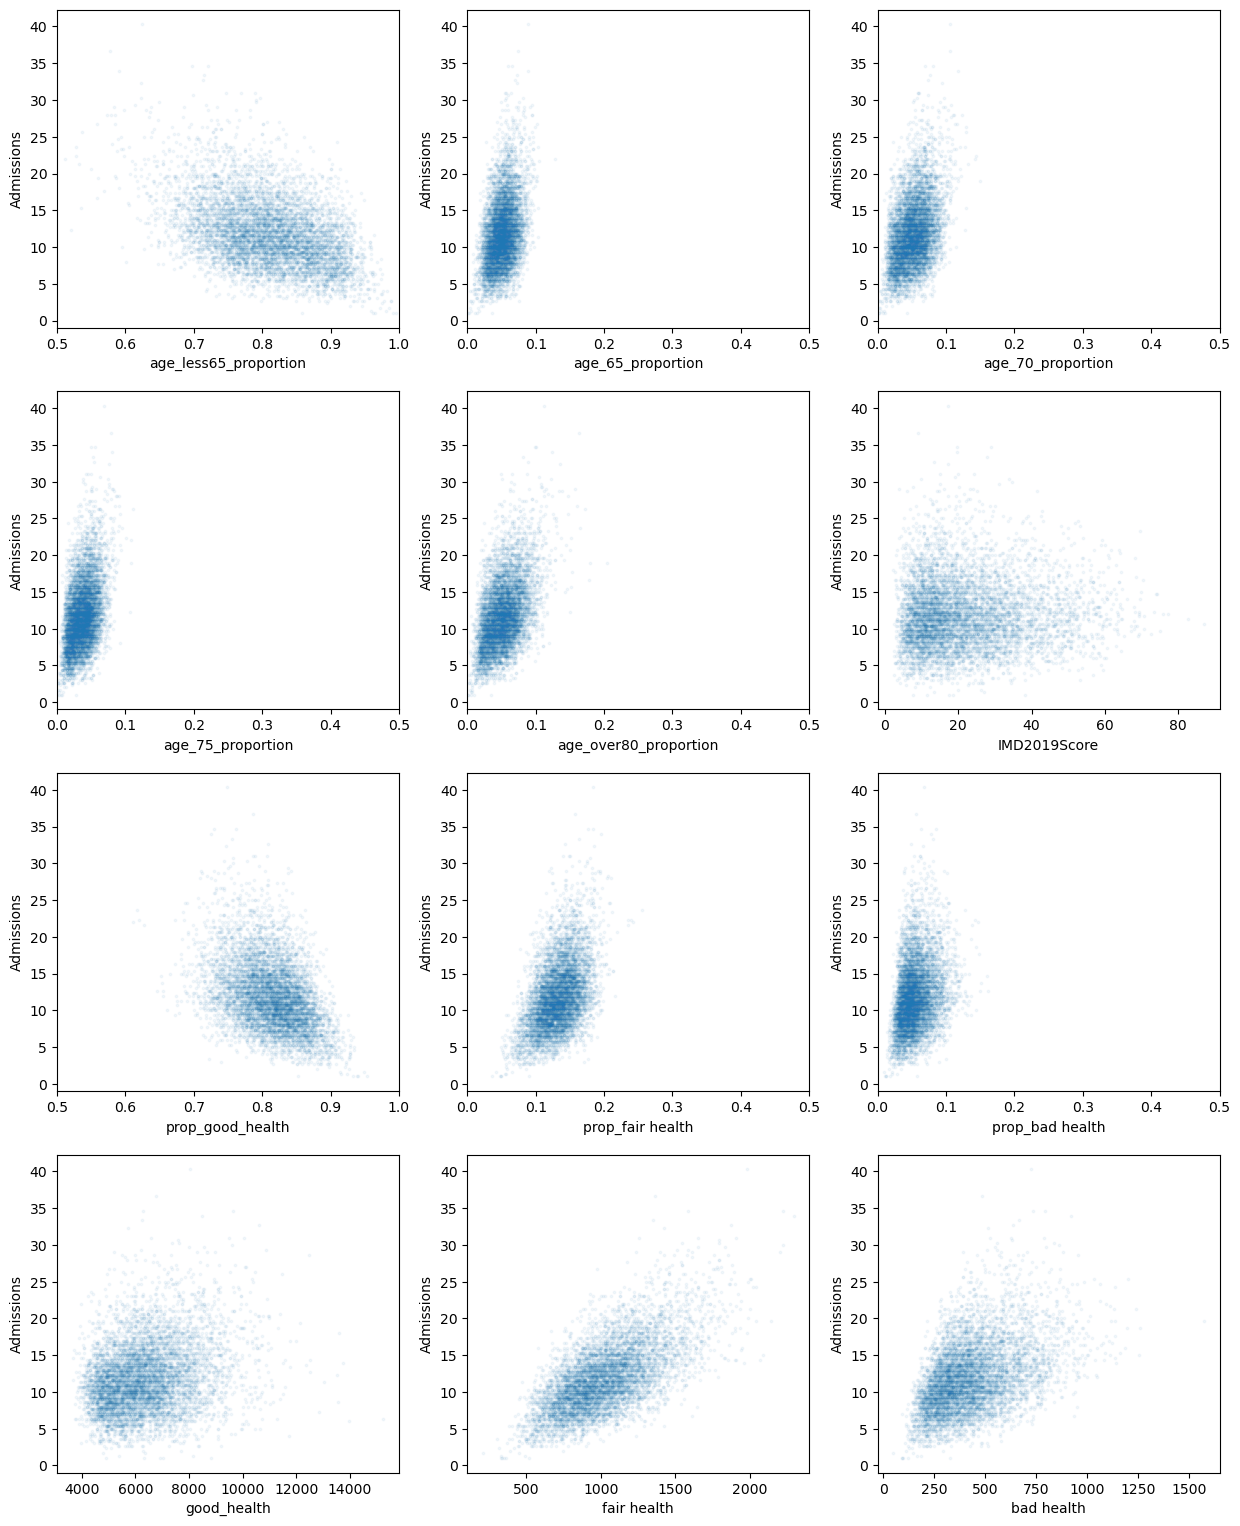

In [35]:
fig, axs = plt.subplots(4, 3, figsize=(15, 19))

for c, col in enumerate(cols_to_check):
    ax = axs[c // 3, c % 3]
    ax.scatter(df_stats[col], df_stats['admissions'], s=3, alpha=0.05)
    ax.set_xlabel(col)
    ax.set_ylabel('Admissions')
    if 'prop' in col:
        if (('less' in col) | ('good' in col)):
            ax.set_xlim(0.5, 1)
        else:
            ax.set_xlim(0, 0.5)
plt.show()

## Compare proportions

Does one proportion increasing always mean another decreasing?

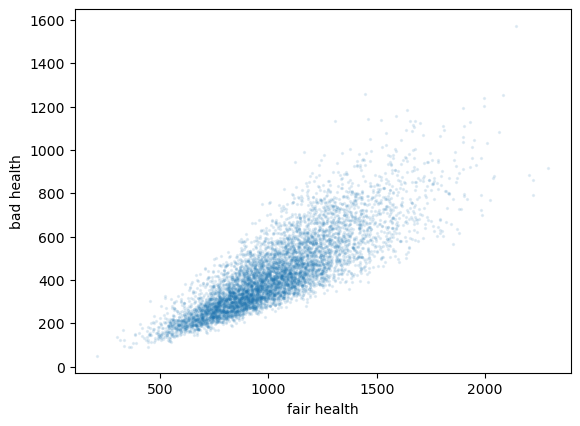

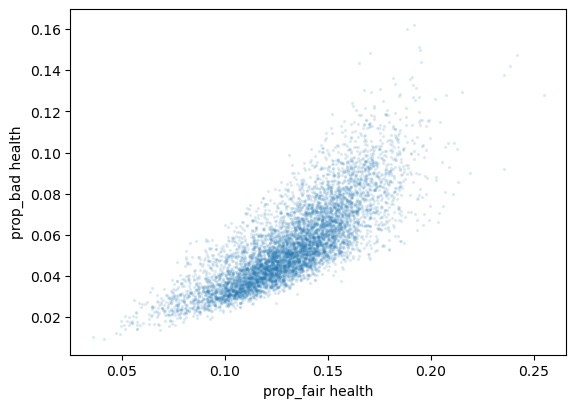

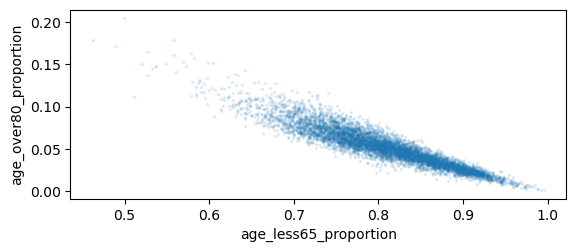

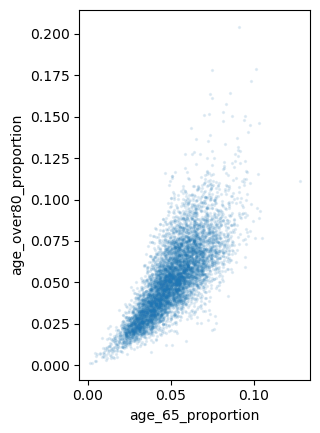

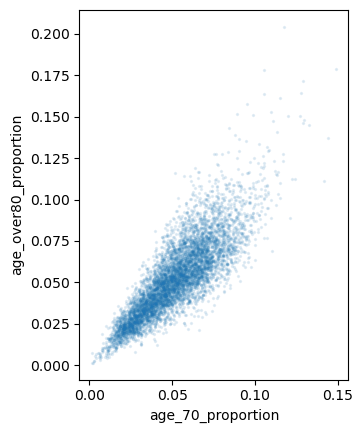

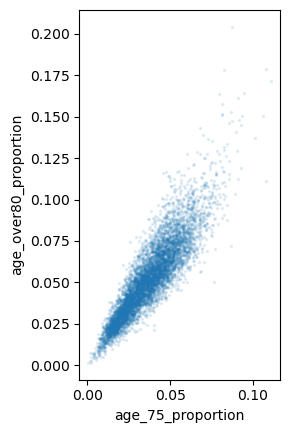

In [30]:
col_pairs = [
    ['fair health', 'bad health'],
    ['prop_fair health', 'prop_bad health'],
    ['age_less65_proportion', 'age_over80_proportion'],
    ['age_65_proportion', 'age_over80_proportion'],
    ['age_70_proportion', 'age_over80_proportion'],
    ['age_75_proportion', 'age_over80_proportion'],
]

for x_col, y_col in col_pairs:
    fig, ax = plt.subplots()
    
    ax.scatter(df_stats[x_col], df_stats[y_col], s=2, alpha=0.1)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_aspect('equal')
    
    plt.show()

## Correlation with health

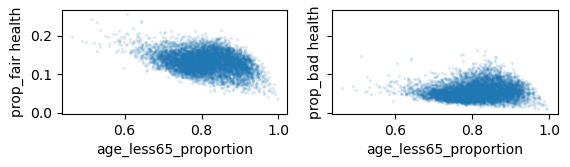

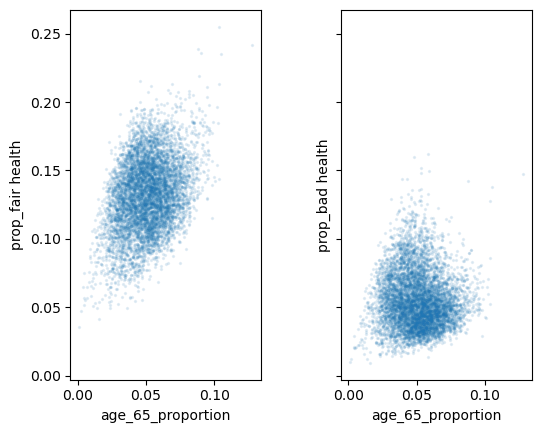

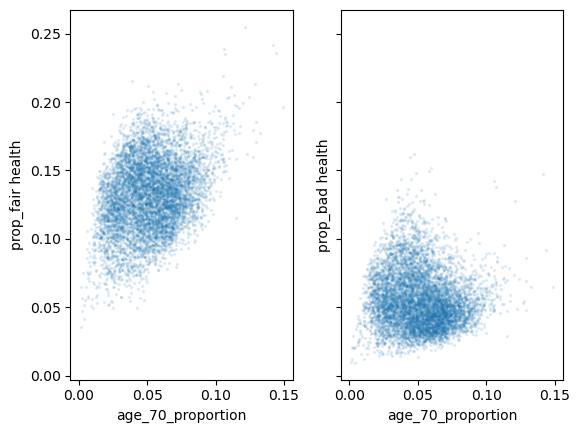

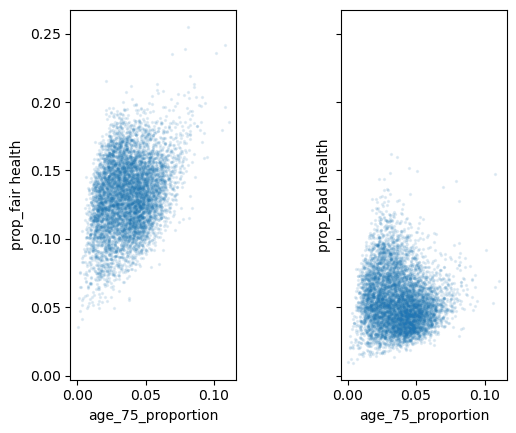

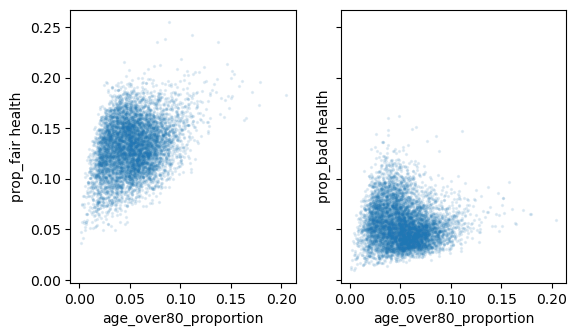

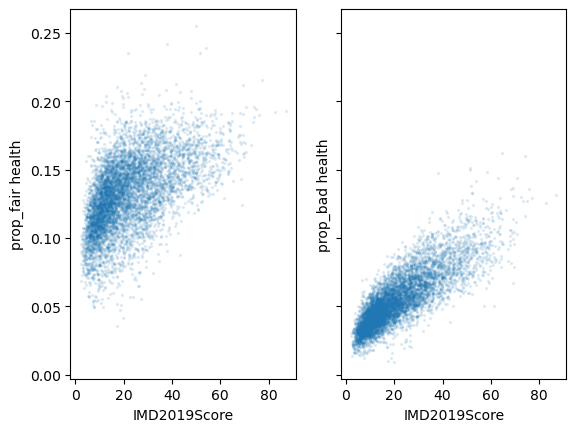

In [36]:
col_pairs = [
    ['age_less65_proportion', ['prop_fair health', 'prop_bad health']],
    ['age_65_proportion', ['prop_fair health', 'prop_bad health']],
    ['age_70_proportion', ['prop_fair health', 'prop_bad health']],
    ['age_75_proportion', ['prop_fair health', 'prop_bad health']],
    ['age_over80_proportion', ['prop_fair health', 'prop_bad health']],
    ['IMD2019Score', ['prop_fair health', 'prop_bad health']],
]

for x_col, y_cols in col_pairs:
    fig, axs = plt.subplots(1, 2, sharey=True)

    for i, y_col in enumerate(y_cols):
        ax = axs[i]
        ax.scatter(df_stats[x_col], df_stats[y_col], s=2, alpha=0.1)
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        if 'IMD' not in x_col:
            ax.set_aspect('equal')
    
    plt.show()

## IMD vs props fair and bad

In [ ]:
fig, ax = plt.subplots()

ax.scatter(df_stats['IMD2019Score'], (df_stats['fair health'] / df_stats['bad health']), s=2, alpha=0.2)

ax.set_xlabel('IMD')
ax.set_ylabel('Ratio of fair to bad health')
plt.show()

## Fair, bad, admissions

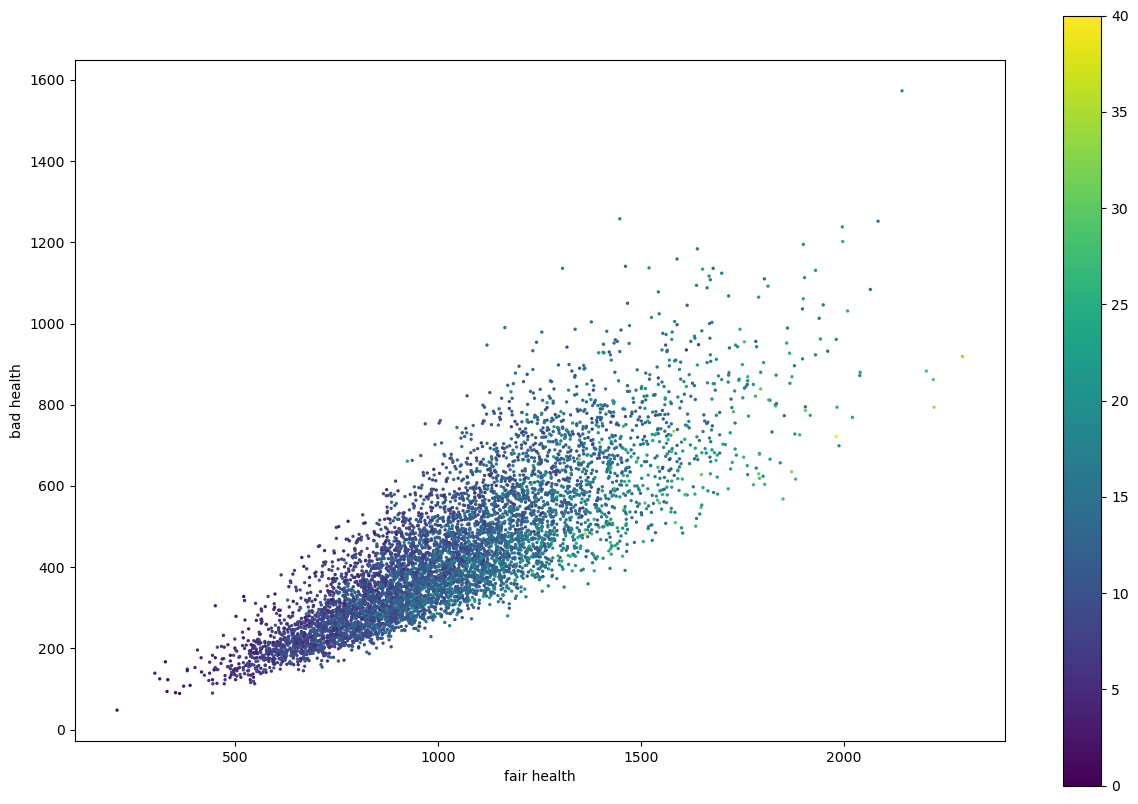

In [47]:
# step = 5
# for ad in np.arange(0, 45, 5):
# mask = (df_stats['admissions'] >= ad) &  (df_stats['admissions'] < ad + step)
fig, ax = plt.subplots(figsize=(15, 10))

df_here = df_stats#.filter(mask)
c = ax.scatter(df_here['fair health'], df_here['bad health'], c=df_here['admissions'], s=2, alpha=1, vmin=0, vmax=40)
plt.colorbar(c)
ax.set_xlabel('fair health')
ax.set_ylabel('bad health')
ax.set_aspect('equal')

plt.show()

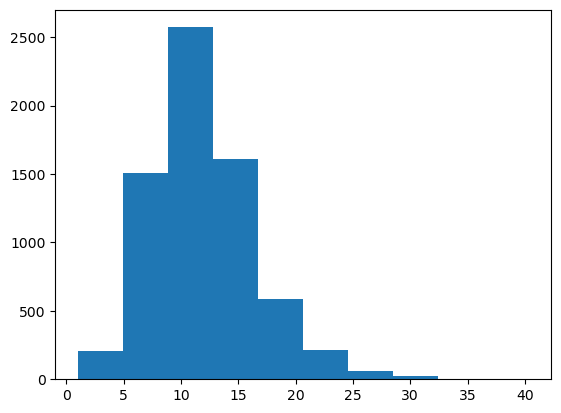

In [48]:
plt.hist(df_stats['admissions'])
plt.show()